# Explore PACE noise

In [5]:
#imports
from importlib import reload

import os
import numpy as np
import xarray

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time

import pandas
import seaborn as sns

from ocpy.pace import io as pace_io

In [2]:
#%matplotlib ipympl

# Load

In [7]:
pfile = os.path.join(os.getenv('OS_COLOR'), 'data', 'PACE',  'PACE_OCI.20240413T175656.L2.OC_AOP.V2_0.NRT.nc')

In [8]:
reload(pace_io)
xds, flags = pace_io.load_oci_l2(pfile)

In [9]:
xds

<xarray.Dataset> Size: 3GB
Dimensions:     (x: 1710, y: 1272, wl: 184)
Coordinates:
    latitude    (x, y) float32 9MB 30.21 30.23 30.25 30.26 ... 53.44 53.44 53.45
    longitude   (x, y) float32 9MB -93.58 -93.51 -93.44 ... -66.46 -66.36 -66.25
    wavelength  (wl) int32 736B 339 341 344 346 348 351 ... 712 713 714 717 719
Dimensions without coordinates: x, y, wl
Data variables:
    Rrs         (x, y, wl) float32 2GB -3.277e+04 -3.277e+04 ... -3.277e+04
    Rrs_unc     (x, y, wl) float32 2GB -3.277e+04 -3.277e+04 ... -3.277e+04
Attributes: (12/45)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20240413T175656.L2.OC_AOP.V2_...
    processing_version:                2.0
    history:                           l2gen par=/data3/sdpsoper/vdc/vpu2/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -65.40468
    geospatial_lon_min:                -103.36526
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9942150712013245

## Polish up 

In [10]:
xds['Rrs'] = xarray.where(xds['Rrs']>-10, xds['Rrs'], np.nan)
xds['Rrs'] = xarray.where(xds['Rrs']<100, xds['Rrs'], np.nan)
# Error too
xds['Rrs_unc'] = xarray.where(xds['Rrs']>-10, xds['Rrs_unc'], np.nan)
xds['Rrs_unc'] = xarray.where(xds['Rrs']<100, xds['Rrs_unc'], np.nan)

In [11]:
xds_subset = xds.where((xds.longitude > -78) & (xds.longitude < -73))
xds_subset = xds_subset.where((xds_subset.latitude > 33) & (xds_subset.latitude < 40))

# Uncertainty

## Median

In [12]:
med_Rrs_u = np.nanmedian(xds_subset.Rrs_unc.data, axis=(0,1))
#std_Rrs_u = np.nanstd(xds_subset.Rrs_unc.data, axis=(0,1))

In [13]:
#std_Rrs_u

In [14]:
gd_u = np.isfinite(xds_subset.Rrs_unc.data)
gd_xy = np.sum(gd_u, axis=2)
#
ok = np.where(gd_xy > 150)
ok

(array([  0,   0,   0, ..., 505, 506, 506]),
 array([785, 786, 787, ..., 995, 994, 995]))

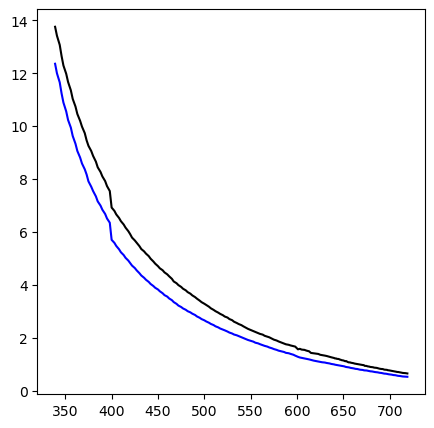

In [15]:
idx = 1000
scale = 1e4
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
ax.plot(xds.wavelength, med_Rrs_u*scale, 'b-')
#  Random
ax.plot(xds.wavelength, xds_subset.Rrs_unc[ok[0][idx], ok[1][idx], :]*scale, 'k-')
#
#ax.fill_between(xds.wavelength, (med_Rrs_u+std_Rrs_u)*scale,
#                (med_Rrs_u-std_Rrs_u)*scale, color='b', alpha=0.5)
#
plt.show()

# Write to disk

In [16]:
np.savez('PACE_error', wave=xds.wavelength, Rrs_u=med_Rrs_u)

In [18]:
df = pandas.DataFrame(dict(wave=xds.wavelength, PACE_sig=med_Rrs_u))
df.to_csv('PACE_error.csv', index=False)

# $R_{\rm rs}$

In [53]:
med_Rrs = np.nanmedian(xds_subset.Rrs.data, axis=(0,1))
#std_Rrs_u = np.nanstd(xds_subset.Rrs_unc.data, axis=(0,1))

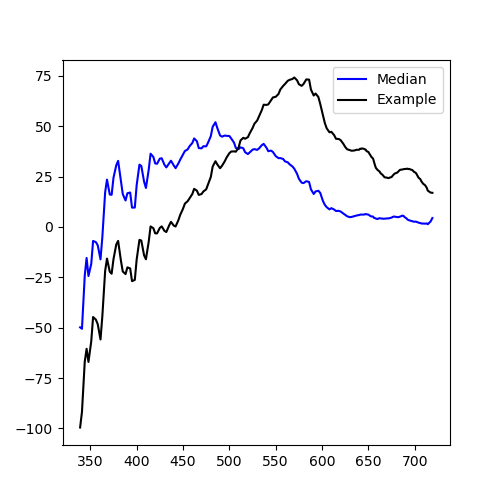

In [69]:
idx = 50000
scale = 1e4
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
ax.plot(xds.wavelength, med_Rrs*scale, 'b-', label='Median')
#  Random
ax.plot(xds.wavelength, xds_subset.Rrs[ok[0][idx], ok[1][idx], :]*scale, 'k-', label='Example')
#
#ax.fill_between(xds.wavelength, (med_Rrs_u+std_Rrs_u)*scale,
#                (med_Rrs_u-std_Rrs_u)*scale, color='b', alpha=0.5)
#
ax.legend()
plt.show()

----

In [57]:
cov = np.array([[6, -3], [-3, 3.5]])
pts = np.random.multivariate_normal([0, 0], cov, size=800)

In [58]:
pts.shape

(800, 2)

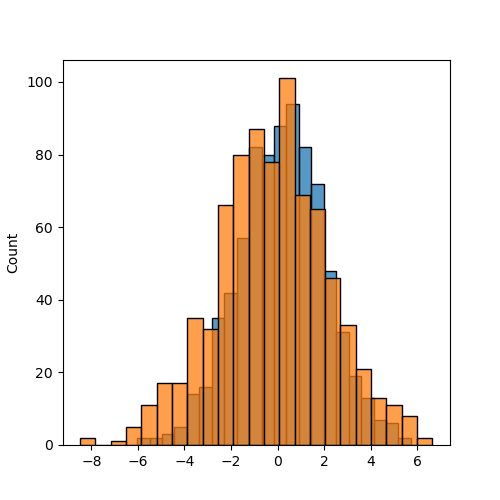

In [67]:
fig = plt.figure(figsize=(5,5))
plt.clf()
ax = plt.gca()

sns.histplot(pts[:,1])
sns.histplot(pts[:,0])

plt.show()

In [65]:
np.std(pts[:,1])**2

3.484670573940217